In [ ]:
import sympy
from sympy import Expr, Eq, latex, plot_implicit
from sympy.core import S, pi, sympify
from sympy.core.logic import fuzzy_bool
from sympy.core.numbers import Rational, oo
from sympy.core.compatibility import ordered
from sympy.core.symbol import Dummy, _uniquely_named_symbol, _symbol
from sympy.simplify import simplify, trigsimp
from sympy.functions.elementary.miscellaneous import sqrt, Max
from sympy.functions.elementary.trigonometric import cos, sin
from sympy.functions.special.elliptic_integrals import elliptic_e
from sympy.geometry.exceptions import GeometryError
from sympy.geometry.line import Ray2D, Segment2D, Line2D, LinearEntity3D
from sympy.polys import DomainError, Poly, PolynomialError
from sympy.polys.polyutils import _not_a_coeff, _nsort
from sympy.solvers import solve
from sympy.solvers.solveset import linear_coeffs
from sympy.utilities.misc import filldedent, func_name
from sympy.geometry.entity import GeometryEntity, GeometrySet
from sympy.geometry.point import Point, Point2D, Point3D
from sympy.geometry.line import Line, Segment
from sympy.geometry.util import idiff
from sympy.utilities.lambdify import lambdify
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Latex

# Практическое занятие 14
# Компьютерный практикум по алгебре на Python
## Кривые второго порядка на плоскости: гипербола
https://ru.wikipedia.org/wiki/%D0%9F%D0%B0%D1%80%D0%B0%D0%B1%D0%BE%D0%BB%D0%B0
https://ru.wikipedia.org/wiki/%D0%93%D0%B8%D0%BF%D0%B5%D1%80%D0%B1%D0%BE%D0%BB%D0%B0_(%D0%BC%D0%B0%D1%82%D0%B5%D0%BC%D0%B0%D1%82%D0%B8%D0%BA%D0%B0)

В SymPy пока нет классов Гипербола и Парабола, создадим их прототипы сами.
Возьмем за образец класс эллипсов

https://github.com/sympy/sympy/blob/70381f282f2d9d039da860e391fe51649df2779d/sympy/geometry/ellipse.py#L38-L1478
https://docs.sympy.org/latest/modules/geometry/ellipses.html?highlight=ellipse#sympy.geometry.ellipse.Ellipse

In [ ]:
class Hyperbola(GeometrySet):
    """
     Attributes
    ==========
    center
    hradius
    vradius
    eccentricity
    periapsis
    focus_distance
    foci
    ==========
    конструктор __new__
    скопирован из Эллипса,
    изменена формула для  hradius и vradius через эсцентриситет
    """
    def __new__(
        cls, center=None, hradius=None, vradius=None, eccentricity=None, **kwargs):
        hradius = sympify(hradius)
        vradius = sympify(vradius)

        eccentricity = sympify(eccentricity)

        if center is None:
            center = Point(0, 0)
        else:
            center = Point(center, dim=2)

        if len(center) != 2:
            raise ValueError('The center of "{0}" must be a two dimensional point'.format(cls))

        if len(list(filter(lambda x: x is not None, (hradius, vradius, eccentricity)))) != 2:
            raise ValueError(filldedent('''
                Exactly two arguments of "hradius", "vradius", and
                "eccentricity" must not be None.'''))

        if eccentricity is not None:
            if hradius is None:
                hradius = vradius / sqrt( eccentricity ** 2 - 1)
            elif vradius is None:
                vradius = hradius * sqrt( eccentricity ** 2 - 1)

        if hradius == 0:
            return "Line"
        if vradius == 0:
            return "Rays"
        return GeometryEntity.__new__(cls, center, hradius, vradius, **kwargs)
    
    @property
    def ambient_dimension(self):
        return 2
    
    @property
    def center(self):
        return self.args[0]

    @property
    def hradius(self):
        return self.args[1]
    
    @property
    def vradius(self):
        return self.args[2]
    
    @property
    def focus_distance(self):
        return sqrt(self.hradius ** 2 + self.vradius ** 2)
    
    @property
    def eccentricity(self):
        """The eccentricity of the ellipse."""
        return self.focus_distance / self.hradius
    @property
    def periapsis(self):
        """The apoapsis of the hyperbola.
        The smallest distance between the focus and the contour."""
        return self.focus_distance - self.hradius
    
    @property
    def foci(self):
        return (self.center + Point(-self.focus_distance, 0), self.center + Point(self.focus_distance, 0))
    
    @property
    def major(self):
        return self.hradius
    
    @property
    def minor(self):
        return self.vradius
    
    def equation(self, x='x', y='y', _slope=None, equation=False):
        """
        Returns the equation of a hyperbola aligned with the x and y axes;
        when slope is given, the equation returned corresponds to a hyperbola 
        with a major axis having that slope.
        Parameters
        ==========
        x : str, optional
            Label for the x-axis. Default value is 'x'.
        y : str, optional
            Label for the y-axis. Default value is 'y'.
        _slope : Expr, optional
                The slope of the major axis. Ignored when 'None'.
        Returns
        =======
        equation : sympy expression   """

        x = _symbol(x, real=True)
        y = _symbol(y, real=True)

        dx = x - self.center.x
        dy = y - self.center.y

        if _slope is not None:
            L = (dy - _slope * dx) ** 2
            l = (_slope * dy + dx) ** 2
            h = 1 + _slope ** 2
            a = h * self.major ** 2
            b = h * self.minor ** 2
            res= l / a - L / b 

        else:
            t1 = (dx / self.hradius) ** 2
            t2 = (dy / self.vradius) ** 2
            res = t1 - t2 
        if not equation:
            return res - 1
        else:
            return Eq(res, 1)       

### Пример 1
Построим нашу первую гиперболу, полуоси 2 и 3.

In [ ]:
Hyp1 = Hyperbola(hradius=2, vradius=3)
Hyp1

Hyperbola(Point2D(0, 0), 2, 3)

Теперь построим гиперболу по горизонтальной полуоси и эксцентриситету

In [ ]:
Hyp2 = Hyperbola(Point(0, 1), hradius=8, eccentricity=S(5) / 4)
Hyp2

Hyperbola(Point2D(0, 1), 8, 6)

Заметим, что vradius автоматически корректно вычислен при построении по формуле $b=a\sqrt{\varepsilon^2-1}$

### Атрибуты класса Hyperbola
**center** 
центр  точка пересечения асимптот гиперболы
**hradius**
горизонтальная полуось
**vradius**
вертикальная полуось	
**eccentricity**
эксцентриситет отношение фокусного расстояния к горизонтальной оси (той, на которой расположены фокусы)	
**periapsis**
перифокусное расстояние (минимальное расстояние от фокуса до точки на эллипсе)	
**focus_distance**
фокусное расстояние - половина расстояния между фокусами	
**foci**
фокусы 
### Пример 2.
Выведем на экран атрибуты гиперболы Hyp1 Примера 1.

In [ ]:
props = {'center': Hyp1.center, 'hradius': Hyp1.hradius,
         'vradius': Hyp1.vradius, 
         'eccentricity': Hyp1.eccentricity, 'periapsis': Hyp1.periapsis,
         'focus\_distance': Hyp1.focus_distance, 'foci': Hyp1.foci}

display(*[Latex(f'{key} = {latex(props[key])}') for key in props.keys()])

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

### Методы класса Hyperbola 
equation(x='x', y='y', _slope=None)- уравнение гиперболы

необязательный аргумент \_slope - наклон главной оси
### Пример 3.
Выведем на экран уравнение гиперболы Hyp2, а также уравнение этой гиперболы, повернутой на угол с тангенсом 2.

In [ ]:
Hyp2.equation()

x**2/64 - (y/6 - 1/6)**2 - 1

In [ ]:
Hyp2.equation(equation=True)

Eq(x**2/64 - (y/6 - 1/6)**2, 1)

In [ ]:
Hyp2.equation(_slope=2, equation=True)

Eq(-(-2*x + y - 1)**2/180 + (x + 2*y - 2)**2/320, 1)

### Пример 4.
Изобразим  графики обеих гипербол Примера 3, исходной и повернутой.
Для того, чтобы изобразить эллипс на графике, нужны его переменные, извлечем их с помощью .free_symbols

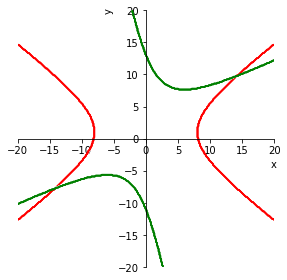

In [ ]:
eq2 = Hyp2.equation(x='x', y='y')
dict_free = {str(a): a for a in eq2.free_symbols}
p = plot_implicit(eq2, (dict_free['x'], -20, 20), (dict_free['y'], -20, 20),
                  line_color='r', aspect_ratio=(1, 1),
                  show=False, adaptive=False)
p.extend(plot_implicit(Hyp2.equation(x='x', y='y', _slope=2),
                       (dict_free['x'], -20, 20), (dict_free['y'], -20, 20),
                  line_color='g', aspect_ratio=(1, 1),
                   show=False, adaptive=False))
p.show()

### Пример 5.
Изобразим на графике гиперболы, полученные из Hyp2 поворотом на некоторый угол.

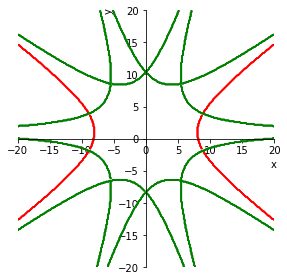

In [ ]:
eq2 = Hyp2.equation(x='x', y='y')
dict_free = {str(q): q for q in eq2.free_symbols}
p = plot_implicit(eq2, (dict_free['x'], -20, 20), (dict_free['y'], -20, 20),
                  line_color='r', aspect_ratio=(1, 1),
                  show=False, adaptive=False)
for i in range(1, 5):
    p.extend(plot_implicit(Hyp2.equation(x='x', y='y',
                                         _slope=sympy.tan(i*pi/5)),
                           (dict_free['x'], -20, 20), (dict_free['y'], -20, 20),
                           line_color='g', aspect_ratio=(1, 1),
                           show=False, adaptive=False))
p.show()

### Пример 6.
Изобразим график гиперболы, используем в легенде возможность вывода по столбцам:

plt.legend(loc='upper left', ncol=2, mode="expand")

**ncol** - количество столбцов

**mode="expand"** - легенда растягивается по ширине графика

Для автоматического формирования красивой подписи в легенде используем

dir1='директриса x = latex(S(a)**2/c, mode='inline')

превращение $a$ в символ с помощью $S(a)$ предотвращает округление

**sympy.utilities.lambdify.lambdify**(args: Iterable, expr, modules=None, printer=None, use_imps=True, dummify=False, cse=False)

lambdify преобразует выражение (expression) SymPy в функцию, предназначенную для быстрых численных (приближенных) вычислений.

<IPython.core.display.Latex object>

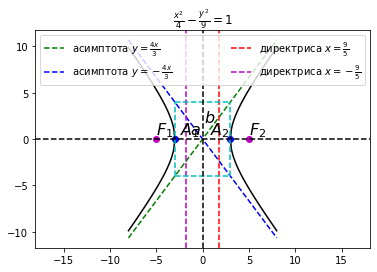

In [ ]:
a = 3
b = 4
Hyp6 = Hyperbola(hradius=a, vradius=b)
c = Hyp6.focus_distance
eq6 = Hyp6.equation(x='x', y='y')
dict_free = {str(a): a for a in eq6.free_symbols}
x = dict_free['x']
y = dict_free['y']
y1, y2 = solve(eq6, y)
display(Latex(f'y_1 = {latex(y1)}, y_2 = {latex(y2)}'))
f_y1, f_y2 = [lambdify(*list(item.free_symbols), item) for item in (y1, y2)]
xy_max = a + float(c.evalf())
X1 = np.linspace(a, xy_max)
X2 = np.linspace(-xy_max, -a)
plt.plot(X1, f_y1(X1), 'k',
         X1, f_y2(X1), 'k',
         X2, f_y1(X2), 'k',
         X2, f_y2(X2), 'k')
x = S('x')
asympt1 = f'асимптота $y={latex(S(b) / a * x)}$'
asympt2 = f'асимптота $y={latex(-S(b) / a * x)}$' 
plt.plot([-xy_max, xy_max], [-xy_max * b / a, xy_max * b / a],
         'g--', label=asympt1)
plt.plot([-xy_max, xy_max], [xy_max * b / a, -xy_max * b / a],
         'b--', label=asympt2)
dir1 = f'директриса $x={latex(S(a) ** 2 / c)}$'
dir2 = f'директриса $x={latex(-S(a) ** 2 / c)}$'
plt.axis('equal')
plt.axvline(x=a ** 2 / c, color='r', linestyle='--', label=dir1)
plt.axvline(x=-a ** 2 / c, color='m', linestyle='--', label=dir2)
plt.plot([-a, -a], [-b, b], 'c--')
plt.plot([a, a], [-b, b], 'c--')
plt.plot([-a, a], [-b, -b], 'c--')
plt.plot([-a, a], [b, b], 'c--')
plt.axhline(y=0, color='k', linestyle='--') 
plt.axvline(x=0, color='k', linestyle='--')
plt.scatter(-c, 0, color='m')
plt.scatter(c, 0, color='m')
plt.scatter(-a, 0, color='b')
plt.scatter(a, 0, color='b')
plt.annotate(r'$F_1$', xy=(-c, 0), xycoords='data', xytext=(0, +5),
             textcoords='offset points', fontsize=16)
plt.annotate(r'$F_2$', xy=(c, 0), xycoords='data', xytext=(0, +5),
             textcoords='offset points', fontsize=16)
plt.annotate(r'$A_1$', xy=(-a, 0), xycoords='data', xytext=(+5, +5),
             textcoords='offset points', fontsize=16)
plt.annotate(r'$A_2$', xy=(a, 0), xycoords='data', xytext=(-20, +5),
             textcoords='offset points', fontsize=16)
plt.annotate(r'$a$', xy=(a, 0), xycoords='data', xytext=(-40, +5),
             textcoords='offset points', fontsize=16)
plt.annotate(r'$b$', xy=(0, b), xycoords='data', xytext=(+1, -20),
             textcoords='offset points', fontsize=16)
plt.title(f'${latex(Hyp1.equation(equation=True))}$')
plt.legend(loc='upper left', ncol=2, mode="expand")

## Уравнения директрис и асимптот при повороте на угол $\alpha$
Пусть  $a$ - горизонтальная полуось, $c$ - фокусное расстояние, $x_0$ - горизонтальная координата центра гиперболы, тогда уравнение директрис 
$$
x = x_0 \pm \frac{a^2}{c}
$$
При повороте на угол $\alpha$ получается уравнение
$$
y = y_0 -{\rm ctg} \alpha(x - x_0) \pm \frac{a^2}{c}\sqrt{1 + {\rm ctg} \alpha}
$$
Уравнение асимптоты
$$
y = y_0 \pm \frac{b}{a}(x - x_0)
$$
При повороте на угол $\alpha$ получаются уравнения
\begin{align*}
y_1 = y_0 + k_1(x - x_0), \quad 
y_2 = y_0 + k_2(x - x_0), \\ 
k_1 = \frac{b + a{\rm tg} \alpha}{a - b{\rm tg} \alpha},\quad 
k_2 = \frac{-b + a{\rm tg} \alpha}{a + b{\rm tg} \alpha}
\end{align*}